In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import timedelta
#from utils import ret_metrics, all_strats

In [214]:
def ret_metrics(daily_ret_df):
    start_date, end_date = daily_ret_df.index[[0,-1]]
    years = (end_date - start_date).days/365
    
    daily_ret_df[daily_ret_df <-1] = -1
    
    #CGR
    CGR = (1 + daily_ret_df).cumprod() - 1
    CAGR = (CGR[-1] + 1)**(1/years) - 1

    #Information Ratios
    sharpe = daily_ret_df.mean()/daily_ret_df.std()
    if np.isnan(sharpe):
        sharpe = 0
    #rolling_sharpe = daily_ret_df.rolling(window=126).mean()/daily_ret_df.rolling(window=126).std()

    #Drawdown
    roll_max = (1+CGR).cummax()
    drawdown = (1+CGR)/roll_max - 1.0
    max_drawdown= drawdown.min()
    drawdown_times = (drawdown < 0).astype(np.int64)
    max_drawdown_duration = drawdown_times.groupby((drawdown_times != drawdown_times.shift()).cumsum()).cumsum().min()
    
    #Win/Loss percentage
    winners = (daily_ret_df > 0).sum() / ((daily_ret_df > 0).sum() + (daily_ret_df < 0).sum())
    losers = (daily_ret_df < 0).sum() / ((daily_ret_df > 0).sum() + (daily_ret_df < 0).sum())
    
    print(f'CAGR: {np.round(100*CAGR,2)}% \
          \nAnnual Sharpe Ratio: {round(252**0.5 * sharpe,2)} \
          \nWin Percetage: {np.round(100*winners, 2)}% \
          \nLoss Percetage: {np.round(100*losers, 2)}% \
          \nMax win: {np.round(100*daily_ret_df.max(),2)}% \
          \nMax Loss: {np.round(100*daily_ret_df.min(),2)}% \
          \nAverage Win/Loss: {np.round(100*daily_ret_df.mean(), 2)}% \
          \nMax Drawdown: {np.round(100*max_drawdown,2)}% \
          \nMax Drawdown Duration: {max_drawdown_duration} \
          \n\n')
    
    CGR.plot()
    plt.title('Cummulative Growth')
    plt.show()
    
    drawdown.plot()
    plt.title('Drawdown')
    plt.show()
    #return drawdown

def all_strats(daily_rets, weights):
    if np.sum(weights) != 1:
        raise ValueError('Weights do not add to 1')
    total_daily_rets = 0
    for i in range(len(daily_rets)):
        total_daily_rets = total_daily_rets + daily_rets[i]*weights[i]
    return total_daily_rets

def long_short_mean_reversion(ret, ret_threshhold = False, kelly=0, transaction_percentage = 0.015):
    market_ret = ret.mean(axis=1)
    weights = - ret.add(- market_ret, axis=0).fillna(0)
    
    if ret_threshhold:
        weights[(abs(weights) < ret_threshhold[0])] = 0
        weights[(abs(weights) > ret_threshhold[1])] = 0
        
    weights = weights.div(abs(weights).sum(axis=1), axis = 0)
    dailyret = (weights.shift(1)*ret).sum(axis=1, skipna=True) - transaction_percentage*(abs(weights.diff()).sum(axis=1))
    
    if kelly:
        kellys = kelly*(dailyret.rolling(window=126).mean()/dailyret.rolling(window=126).var())
        dailyret = kellys.shift(1)*dailyret
    
    return dailyret.fillna(0)

### TODO:
- Get Universe of  Clean Data
- Research what is not going well with the strategy

In [190]:
consumer_symbols = pd.read_csv('symbols_consumer_nd.csv')['Symbol']
tech_symbols = pd.read_csv('tech_nasdaq.csv')['Symbol']
energy_symbols = pd.read_csv('energy_nasdaq.csv')['Symbol']
finance_symbols = pd.read_csv('finance_nasdaq.csv')['Symbol']
basic_industries_symbols = pd.read_csv('basic_industries_nasdaq.csv')['Symbol']

symbols = pd.DataFrame({'Energy': energy_symbols, 'Tech':tech_symbols, 'Consumer': consumer_symbols, 'Finance': finance_symbols, 'Basic Industries': basic_industries_symbols})

all_tickers = []
for s in symbols:
    all_tickers = [*all_tickers, *symbols[s].dropna().values]

n = symbols.shape[1]

In [191]:
tickers = ""
for ticker in all_tickers:
    tickers += " " +ticker
tickers = tickers[1:]
data = yf.Tickers(tickers)
history = data.history(start='2016-04-04')

[*********************100%***********************]  2977 of 2977 completed

14 Failed downloads:
- AMAOW: None
- GBRGR: None
- GBLIL: None
- MPACR: None
- GECCM: None
- SFB: None
- ADOCR: None
- TRKAW: None
- ESSCR: None
- ZGYHR: None
- BRLIR: None
- ALACR: None
- VTAQR: None
- ACQRW: None


In [227]:
#Market ret as mean
cl = history['Close']
all_dailyret = pd.DataFrame()
for sector in symbols:
    ret = cl[symbols[sector].dropna().str.strip()].pct_change()
    dailyret = long_short_mean_reversion(ret, [0.7, 15]).fillna(0)
    all_dailyret = all_dailyret.append(dailyret, ignore_index=True)
all_dailyret = all_dailyret.transpose()
all_dailyret.columns = symbols.columns

CAGR: 225.52%           
Annual Sharpe Ratio: 2.08           
Win Percetage: 70.82%           
Loss Percetage: 29.18%           
Max win: 59.4%           
Max Loss: -49.18%           
Average Win/Loss: 0.56%           
Max Drawdown: -49.97%           
Max Drawdown Duration: 0           




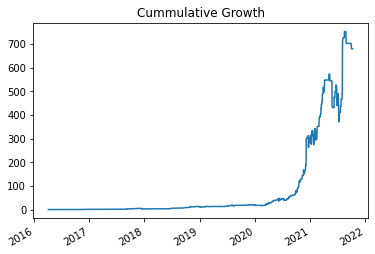

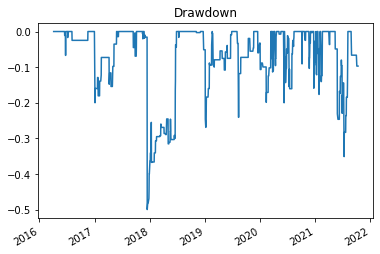

In [228]:
ret_metrics((1/n)*all_dailyret.sum(axis=1))

CAGR: -26.67%           
Annual Sharpe Ratio: 1.29           
Win Percetage: 38.71%           
Loss Percetage: 61.29%           
Max win: 72.15%           
Max Loss: -95.74%           
Average Win/Loss: 0.77%           
Max Drawdown: -96.34%           
Max Drawdown Duration: 0           




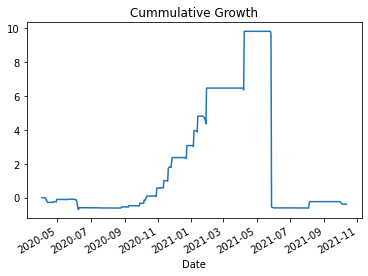

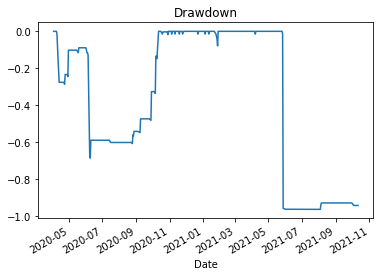

In [174]:
ret_threshhold = [0.7,15]
transaction_percentage = 0.015
kelly_gain = 0

ret = history['Close'][symbols['Energy'].dropna()].pct_change()

market_ret = ret.mean(axis=1)
weights = - ret.add(- market_ret, axis=0).fillna(0)

weights[(abs(weights) < ret_threshhold[0])] = 0
weights[(abs(weights) > ret_threshhold[1])] = 0

weights = weights.div(abs(weights).sum(axis=1), axis = 0).fillna(0)

dailyret = (weights.shift(1)*ret).sum(axis=1, skipna=True) - transaction_percentage*(abs(weights.diff()).sum(axis=1))

if kelly_gain:
    print("Kelly")
    kelly = kelly_gain*(dailyret.rolling(window=126).mean()/dailyret.rolling(window=126).var())
    dailyret = kelly.shift(1)*dailyret

ret_metrics(dailyret)

<AxesSubplot:xlabel='Date'>

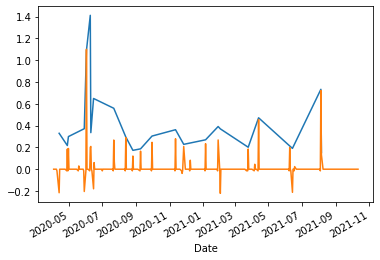

In [131]:
#print(market_ret.reset_index().iloc[market_ret.argmax()])
ind = abs(dailyret) > 0.1
excess_ret = ret.add(- market_ret, axis=0).fillna(0)
analysis = pd.DataFrame({'Daily Returns': dailyret,
                         'Market Returns':market_ret,
                         'Max Excess':abs(excess_ret).max(axis=1),
                         'Mean Excess': abs(excess_ret).mean(axis=1),
                         'Median Excess': abs(excess_ret).median(axis=1),
                         'Std Excess': abs(excess_ret).std(axis=1)
                        })

analysis[ind]
abs(excess_ret[ind]).max(axis=1).plot()
dailyret.plot()

CAGR: 28.23%           
Annual Sharpe Ratio: 1.11           
Win Percetage: 78.95%           
Loss Percetage: 21.05%           
Max win: 39.55%           
Max Loss: -71.28%           
Average Win/Loss: 0.43%           
Max Drawdown: -71.66%           
Max Drawdown Duration: 0           




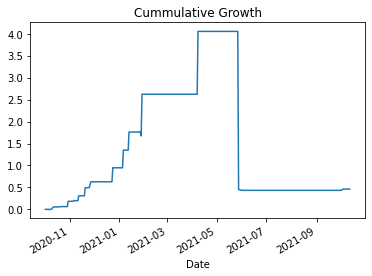

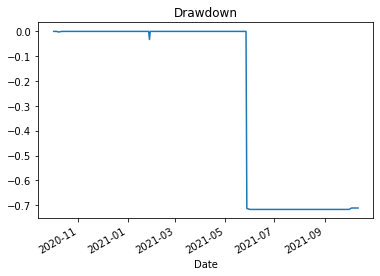

In [16]:
ret_threshhold = 0.8
transaction_percentage = 0.015
kelly_gain = 0.25

ret = history['Close'][symbols['Energy'].dropna()].pct_change()

market_ret = ret.mean(axis=1)
weights = - ret.add(- market_ret, axis=0).fillna(0)

weights[abs(weights) < ret_threshhold] = 0
weights = weights.div(abs(weights).sum(axis=1), axis = 0)

dailyret = (weights.shift(1)*ret).sum(axis=1, skipna=True) - transaction_percentage*(abs(weights.diff()).sum(axis=1))

if kelly_gain:
    kelly = kelly_gain*(dailyret.rolling(window=126).mean()/dailyret.rolling(window=126).var())
    dailyret = kelly.shift(1)*dailyret

ret_metrics(dailyret)

CAGR: 56.54%           
Annual Sharpe Ratio: 1.55           
Win Percetage: 53.76%           
Loss Percetage: 46.24%           
Max win: 89.72%           
Max Loss: -96.77%           
Average Win/Loss: 0.94%           
Max Drawdown: -99.67%           
Max Drawdown Duration: 0           




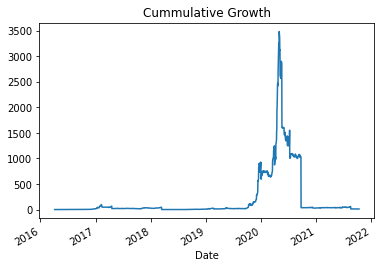

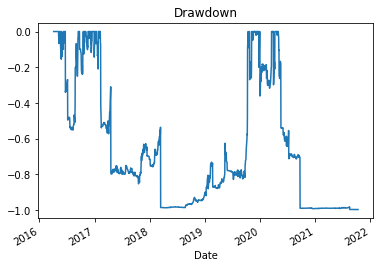

In [198]:
op = history['Open']
cl = history['Close']

ret = (op - cl.shift(1))/cl.shift(1)

market_ret = ret.mean(axis=1)
weights = - ret.add(- market_ret, axis=0).fillna(0)
ret_threshhold = 0.15
weights[abs(weights) < ret_threshhold] = 0
weights = weights.div(abs(weights).sum(axis=1), axis = 0)

dailyret_2 = (weights*(cl-op)/op).sum(axis=1, skipna=True).div(abs(weights).sum(axis=1), axis=0).fillna(0) - 2*0.015*(abs(weights.diff()).sum(axis=1))

kelly = 0.25*(dailyret_2.rolling(window=25).mean()/dailyret_2.rolling(window=25).var())
max_leverage = 4
kelly[kelly >= max_leverage] = max_leverage
dailyret_2 = (kelly.shift(1)*dailyret_2).fillna(0)

ret_metrics(dailyret_2)

CAGR: 118.94% 
Annual Sharpe Ratio: 1.68           
Win Percetage: 55.34%           
Loss Percetage: 44.66%           
Max win: 38.17%           
Max Loss: -22.47%           
Average Win/Loss: 0.36%           
Max Drawdown: -22.47%           
Max Drawdown Duration: 0           




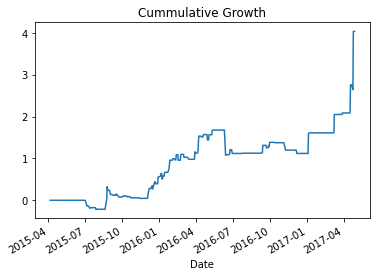

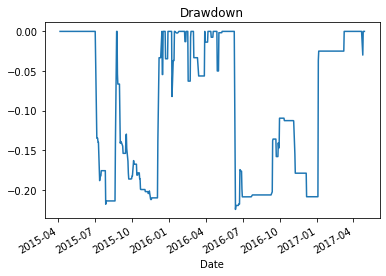

In [62]:
dailyrets = all_strats([dailyret_1, dailyret_2], [0.5, 0.5])
ret_metrics(dailyrets.fillna(0))

In [268]:
sp = yf.Tickers('^GSPC SPY').history(start='2020-10-1')['Close']

[*********************100%***********************]  2 of 2 completed


CAGR: 1.81%           
Annual Sharpe Ratio: 0.26           
Win Percetage: 55.71%           
Loss Percetage: 44.29%           
Max win: 1.43%           
Max Loss: -2.12%           
Average Win/Loss: 0.01%           
Max Drawdown: -6.44%           
Max Drawdown Duration: 0           




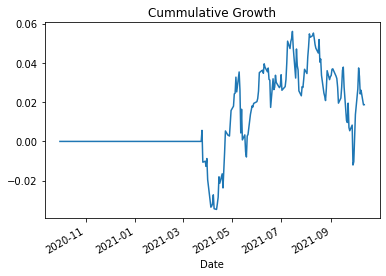

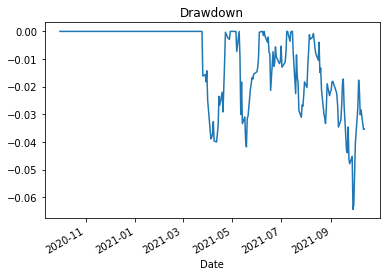

CAGR: 30.49%           
Annual Sharpe Ratio: 2.03           
Win Percetage: 55.77%           
Loss Percetage: 44.23%           
Max win: 2.42%           
Max Loss: -3.42%           
Average Win/Loss: 0.11%           
Max Drawdown: -7.35%           
Max Drawdown Duration: 0           




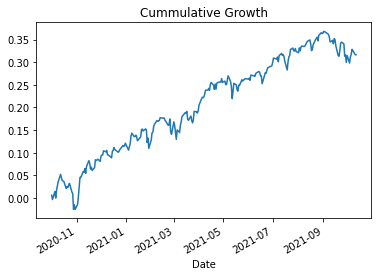

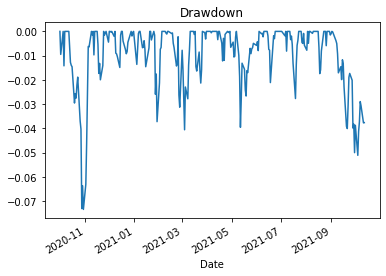

In [272]:
market = sp['^GSPC']
spy = sp['SPY']
ret = spy.pct_change()
market_ret = market.pct_change()
ma_ret = market_ret.rolling(120).mean()

excess_ret = ret - ma_ret
#excess_ret[abs(excess_ret) < 0.005] = 0
weights = -np.sign(excess_ret)

dailyret = (weights.shift(1)*ret).fillna(0)

ret_metrics(dailyret)
ret_metrics(ret)